In [31]:
#import necessary libraries

import numpy as np
import scipy as sp

In [44]:
"""
Definining the Operators
- Morse Hamiltonian
- Always-on Hamiltonian
- Displacement Gate
- Qubit xy Rotation Gate
"""

# Parameters for Morse Time Evolution
time = 2
mass = 1
diss_energy = 8
width_param = 1
equib_length = 0

hbar = 1    
# 6.62607015 * (10 ** (-34))

# Truncation for the oscillator Fock space
N = np.sqrt(2 * mass * diss_energy) / (width_param * hbar)
N = (int) (N - (1/2))

I_q = np.eye(2) #Identity operator for qubits
I_o = np.eye(N) #Identity operator for qumodes

a = np.diag(np.sqrt(np.arange(1, N)), 1)  # Annihilation operator
adag = a.T.conj()                         # Creation operator
n_op = adag @ a                           # Photon number operator

# Pauli Matrices for qubit
sigma_x = np.array([[0, 1], [1, 0]])
sigma_y = np.array([[0, -1j], [1j, 0]])
sigma_z = np.array([[1, 0], [0, -1]])

omega = 1.0  # Oscillator frequency
chi = 0.01   # Qubit-oscillator coupling

H_always_on = (chi * sigma_z + omega * np.eye(2))  # 2x2 matrix
H_always_on = np.kron(H_always_on, n_op)           # Full H'

# Always-on Time Evolution Gate
def H_On_Evo(t):
    return sp.linalg.expm(-1j * H_always_on * t)

#Dispacement gate 
def displacement(alpha):
    A = alpha * adag - np.conj(alpha) * a
    return sp.linalg.expm(A)

def D_full(alpha):
    return np.kron(I_q, displacement(alpha))

#Qubit XY Rotation Gate
def R_phi(theta, phi):
    op = (np.cos(phi) * sigma_x + np.sin(phi) * sigma_y)
    return sp.linalg.expm(-1j * theta / 2 * op)

def R_full(theta, phi):
    return np.kron(R_phi(theta, phi), I_o)


#Morse Hamiltonian
def H_Morse(u ,de, b, x0):
    """
    Morse Hamiltonian Gate

    Args:
        u (real): reduced mass of diatomic system
        de (real): dissociation energy
        b (real): width parameter
        x0 (real): equilibrium bond length

    Returns:
        csc_matrix: operator matrix
    """
    m_omega = np.sqrt(2 * de * (b ** 2) / u)
    X_op = (a + adag) / np.sqrt(2)
    P_op = 1j * (a - adag) / (np.sqrt(2))
    x_op = X_op * np.sqrt(hbar / (u * m_omega))
    p_op = P_op * np.sqrt(hbar * u * omega)

    kin_op = (p_op @ p_op) / (2 * u)

    exp_term = sp.linalg.expm(-1 * b * (x_op - x0 * np.eye(N)))
    mp_op = de * ((np.eye(N) - exp_term) @ (np.eye(N) - exp_term))

    full_m = kin_op + mp_op

    full_m = np.kron(I_q, full_m) #Embed into full qubit-oscillator hilbert space

    return full_m

def MH_Evo(t, u, de, b, x0):
    return sp.linalg.expm(-1j * H_Morse(u, de, b, x0) * t)

In [45]:
# Build the Gate Sequence

def gate_seq(params, d):
    """
    Builds the Gate Sequence

    Params: Each layer is a list of 4 parameters
    1. alpha_real - real part of alpha which shifts position
    2. alpha_imag - imaginary part of alpha which shifts momentum
    3. theta - one of the parameters for the xy qubit rotation gate
    4. phi - one of the parameters for the xy qubit rotaation gate
    
    """
    U = np.eye(2 * N, dtype=complex)
    for j in range(d):
        alpha_real = params[4*j]
        alpha_imag = params[4*j+1]
        theta = params[4*j+2]
        phi = params[4*j+3]
        
        D = D_full(alpha_real + 1j * alpha_imag)
        R = R_full(theta, phi)
        V = H_On_Evo(time)

        U = U @ V @ R @ D
    return U

In [46]:
# Define the Cost Function

# The cost function likely needs the most work


def fidelity_loss(params, d, U_target):
    U = gate_seq(params, d)
    dim = U.shape[0]
    fid = np.abs(np.trace(U.conj().T @ U_target))/ (dim)
    return 1 - fid


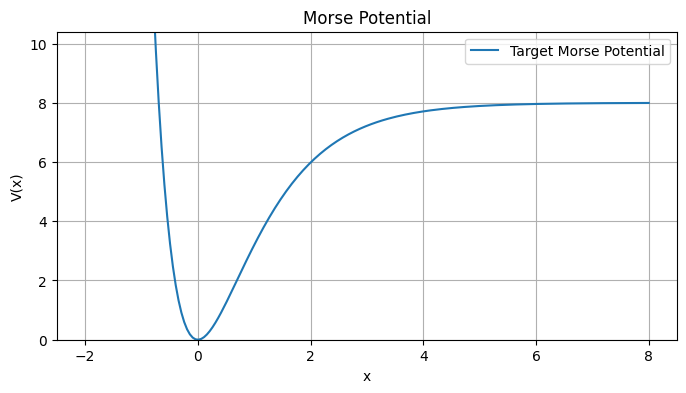

In [47]:
import matplotlib.pyplot as plt

# Create an instance of the morse time evolution
morse_to_optimize = MH_Evo(t=time, u=mass, de=diss_energy, b=width_param, x0=equib_length)

#Plot the Morse Potential

# Position axis
x = np.linspace(-2, 8, 200)

# Morse potential
V_Target = diss_energy * (1 - np.exp(-width_param * (x - equib_length)))**2

# Plot
plt.figure(figsize=(8, 4))
plt.plot(x, V_Target, label='Target Morse Potential')
plt.xlabel('x')
plt.ylabel('V(x)')
plt.ylim(0, diss_energy * 1.3)  # Adjust the 1.2 factor as needed
plt.title('Morse Potential')
plt.grid(True)
plt.legend()
plt.show()

In [48]:
# Optimize

d = 10                                          # number of gate layers
num_params = d * 4                              # [Re(α), Im(α), θ, φ] per gate

# Provides small initial guess near 0
init_guess = np.random.rand(num_params) * 0.1   



result = sp.optimize.minimize(
    #optimize will make guesses for parameteres of fidelity_loss that minimize its return values
    fidelity_loss,          
    init_guess,
    args=(d, morse_to_optimize),
    method='BFGS',
    options={'disp': True}
)

optimal_params = result.x

# Print the Optimized Parameters

omega = 1.0  # Oscillator frequency
chi = 0.1    # Qubit-oscillator coupling

def print_optimal_params(params, d):
    print(f"Fock Space Truncation         = {N}")
    print()
    print("Oscillator Paremeters:")
    print(f"    oscillator frequency      = {omega}")
    print(f"    qubit-oscillator coupling = {chi}")
    print()
    print("Morse Parameters Used:")
    print(f"    hbar           = {hbar}")
    print(f"    time           = {time}")
    print(f"    mass           = {mass}")
    print(f"    diss_energy    = {diss_energy}")
    print(f"    width_param    = {width_param}")
    print(f"    equilib_length = {equib_length}")

    print()
    print("-" * 30)

    print("Optimized Paramters")
    for i in range(d):
        re_alpha = params[i * 4 + 0]
        im_alpha = params[i * 4 + 1]
        theta    = params[i * 4 + 2]
        phi      = params[i * 4 + 3]
        
        print(f"Gate {i+1}:")
        print(f"  α     = {re_alpha:.4f} + {im_alpha:.4f}j")
        print(f"  θ     = {theta:.4f}")
        print(f"  φ     = {phi:.4f}")
        print("-" * 30)

# After optimization
print_optimal_params(optimal_params, d)


Optimization terminated successfully.
         Current function value: 0.000002
         Iterations: 701
         Function evaluations: 30873
         Gradient evaluations: 753
Fock Space Truncation         = 3

Oscillator Paremeters:
    oscillator frequency      = 1.0
    qubit-oscillator coupling = 0.1

Morse Parameters Used:
    hbar           = 1
    time           = 2
    mass           = 1
    diss_energy    = 8
    width_param    = 1
    equilib_length = 0

------------------------------
Optimized Paramters
Gate 1:
  α     = -0.8116 + -1.6041j
  θ     = -0.1527
  φ     = -0.9979
------------------------------
Gate 2:
  α     = -0.0479 + 0.0715j
  θ     = 1.0817
  φ     = -0.8304
------------------------------
Gate 3:
  α     = 0.2191 + -1.8644j
  θ     = 0.0392
  φ     = 0.7922
------------------------------
Gate 4:
  α     = 0.7711 + -0.7616j
  θ     = -1.3192
  φ     = -0.0791
------------------------------
Gate 5:
  α     = 1.4395 + -0.6536j
  θ     = 0.6284
  φ     = 0.4677

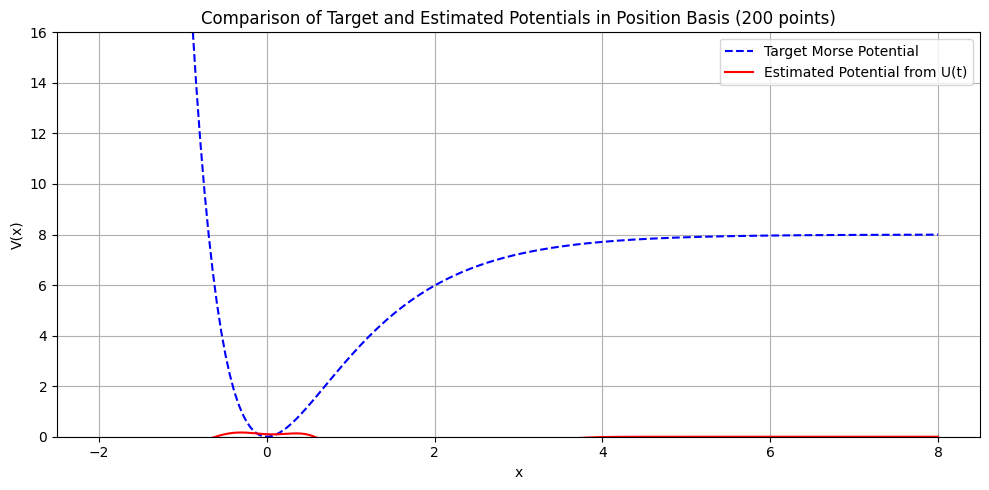

In [51]:
#Build the Unitary Generated
morse_generated = gate_seq(optimal_params, d)

def fock_basis_to_position(x, N, m=1.0, hbar=1.0, omega=1.0):
    """
    Returns T[i, n] = ⟨x_i | n⟩, i.e., harmonic oscillator wavefunction for n-th Fock state at position x_i
    """
    xi = np.sqrt(m * omega / hbar) * x
    prefactor = (m * omega / (np.pi * hbar))**0.25
    T = np.zeros((len(x), N), dtype=complex)

    for n in range(N):
        norm = 1 / np.sqrt(2**n * sp.special.factorial(n))
        Hn = sp.special.eval_hermite(n, xi)
        psi_n = prefactor * norm * np.exp(-0.5 * xi**2) * Hn
        T[:, n] = psi_n

    return T


# Extract the Hamiltonian
H_estimated = (1j / time) * sp.linalg.logm(morse_generated)

# T is now 200 x N
T = fock_basis_to_position(x, N=H_estimated.shape[0])

# Transform to position basis
H_pos = T @ H_estimated @ T.conj().T  # Now 200 x 200

# Diagonal = potential energy values
V_estimated_position = np.real(np.diag(H_pos))

V_target = diss_energy * (1 - np.exp(-width_param * (x - equib_length)))**2

plt.figure(figsize=(10, 5))
plt.plot(x, V_target, label='Target Morse Potential', linestyle='--', color='blue')
plt.plot(x, V_estimated_position, label='Estimated Potential from U(t)', linestyle='-', color='red')

plt.xlabel('x')
plt.ylabel('V(x)')
plt.ylim(0, diss_energy * 2)  # Adjust the 1.2 factor as needed
plt.title('Comparison of Target and Estimated Potentials in Position Basis (200 points)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()
